# Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from helper_functions import *

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
import tensorflow_datasets as tfds

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.config.experimental.get_device_details(gpus[0])

{'device_name': 'NVIDIA GeForce RTX 5070 Ti', 'compute_capability': (12, 0)}

# Importing Food101 dataset

In [4]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

# Investigate our Food101 dataset
* what is the input data shape, dtype, min and max pixel values
* Are the images of a consistent size?
* Are they scaled?
* Are the data in batches?
* How do the labels look like? (are they one-hot or labeled encoded?)
* What are the class names?
* Do labels match the class names?

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [6]:
class_names = ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [7]:
for image, label in train_data.take(3):
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Image pixel value, min: {tf.reduce_min(image)}, max: {tf.reduce_max(image)}
  Label dtype: {label.dtype}
  Label value: {label}
  Label value (str format): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Image pixel value, min: 0, max: 255
  Label dtype: <dtype: 'int64'>
  Label value: 56
  Label value (str format): huevos_rancheros
  

  Image shape: (384, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Image pixel value, min: 0, max: 255
  Label dtype: <dtype: 'int64'>
  Label value: 76
  Label value (str format): pizza
  

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Image pixel value, min: 0, max: 255
  Label dtype: <dtype: 'int64'>
  Label value: 21
  Label value (str format): chocolate_cake
  


In [8]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 66,  79,  53],
        [ 67,  80,  54],
        [ 68,  80,  56],
        ...,
        [ 67,  90,  98],
        [ 64,  87,  95],
        [ 62,  85,  93]],

       [[ 66,  79,  53],
        [ 67,  80,  54],
        [ 68,  80,  56],
        ...,
        [ 82, 102, 111],
        [ 78,  98, 107],
        [ 75,  95, 104]],

       [[ 67,  79,  55],
        [ 68,  80,  56],
        [ 69,  81,  57],
        ...,
        [ 94, 111, 119],
        [ 91, 108, 116],
        [ 88, 105, 113]],

       ...,

       [[ 27,   7,   6],
        [ 26,   6,   5],
        [ 25,   5,   6],
        ...,
        [ 18,  16,  21],
        [ 16,  15,  23],
        [ 16,  15,  23]],

       [[ 28,   7,   6],
        [ 26,   6,   5],
        [ 25,   5,   4],
        ...,
        [ 17,  15,  20],
        [ 16,  13,  22],
        [ 17,  14,  23]],

       [[ 27,   6,   5],
        [ 26,   5,   4],
        [ 25,   5,   4],
        ...,
        [ 16,  14,  1

## Conclusions drawn
* Image sizes are not consisent, we must resize all image tensors for consistency
* Image tensors are in the wrong datatype (typically should be `tf.float32`)
* Images are not scaled (pixel values between 0 & 1), but this is not an issue as we are going to use `EfficientNetB0` as our backbone
* Labels are labeled encoded (during compilation we must use `SpareCaegoricalCrossentropy`)

## Let's visualize an image

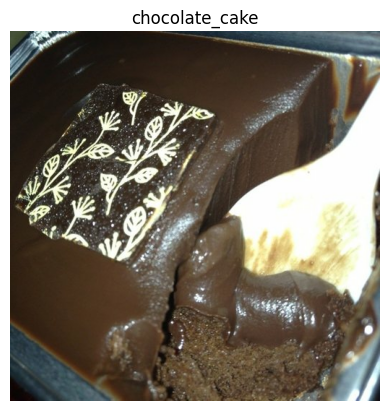

In [9]:
plt.imshow(image)
plt.axis("off")
plt.title(class_names[label.numpy()]);

# Constructing an input pipeline

In [10]:
train_data = train_data.map(image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)  # Apply preprocessing with parallelism
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)  # Shuffle, batch, and prefetch

test_data = test_data.map(image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)  # Apply preprocessing with parallelism
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)  # Batch and prefetch

In [11]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Starting our experiments

![alt text](hmm.png)

## Experiment 1: Impact of Data Augmentation on Model Performance

**Objective:**  
Evaluate whether data augmentation improves model accuracy.

### model_0 construction and training

In [13]:
model_0 = build_model(model_name="model_0",
                      num_classes=len(class_names),
                      backbone=EfficientNetB0,
                      with_data_aug=False,
                      normalize=False,
                      add_bottleneck_layer=False,
                      with_regularization_and_dropout=False,
                      use_transfer_learning=True)
model_0.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070 Ti, compute capability 12.0


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070 Ti, compute capability 12.0


<Policy "mixed_float16">
Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 logits_layer (Dense)        (None, 101)               129381    
                                                                 
 activation_output_layer (Ac  (None, 101)              0         
 tivation)                                                       
                                                                 
Total params: 4,178,952
Trainable 

In [14]:
display_layers_info(model_0)


          Layer name: input_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float32'>
          Layer compute dtype: float32

    

          Layer name: efficientnetb0
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: global_average_pooling_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: logits_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: activation_output_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float32'>
          Layer compute dtype: float32

    


In [15]:
history_model_0 = model_0.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=prepare_callbacks(checkpoint_name="feature_extraction_without_data_augmentation_model_0",
                                                          logs_name="feature_extraction_without_data_augmentation_model_0")
                              )

Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.7203 - accuracy: 0.5795
Epoch 1: val_accuracy improved from -inf to 0.69889, saving model to ./checkpoints\feature_extraction_without_data_augmentation_model_0.weights.h5
2368/2368 [==============================] - 350s 24ms/step - loss: 1.7203 - accuracy: 0.5795 - val_loss: 1.1332 - val_accuracy: 0.6989 - lr: 0.0010
Epoch 2/5
2366/2368 [============================>.] - ETA: 0s - loss: 1.2012 - accuracy: 0.6882
Epoch 2: val_accuracy improved from 0.69889 to 0.71504, saving model to ./checkpoints\feature_extraction_without_data_augmentation_model_0.weights.h5
2368/2368 [==============================] - 55s 23ms/step - loss: 1.2011 - accuracy: 0.6883 - val_loss: 1.0428 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 3/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.0563 - accuracy: 0.7226
Epoch 3: val_accuracy improved from 0.71504 to 0.72722, saving model to ./checkpoints\feature_extraction_without_da

In [16]:
save_training_history(history_model_0, "model_0")

Training history saved to ./histories/json/model_0.json


In [42]:
model_0.load_weights("checkpoints/feature_extraction_without_data_augmentation_model_0.weights.h5")
result_model_0 = model_0.evaluate(test_data)
result_model_0

790/790 [==============================] - 17s 20ms/step - loss: 0.9840 - accuracy: 0.7313


[0.9840071797370911, 0.7312871217727661]

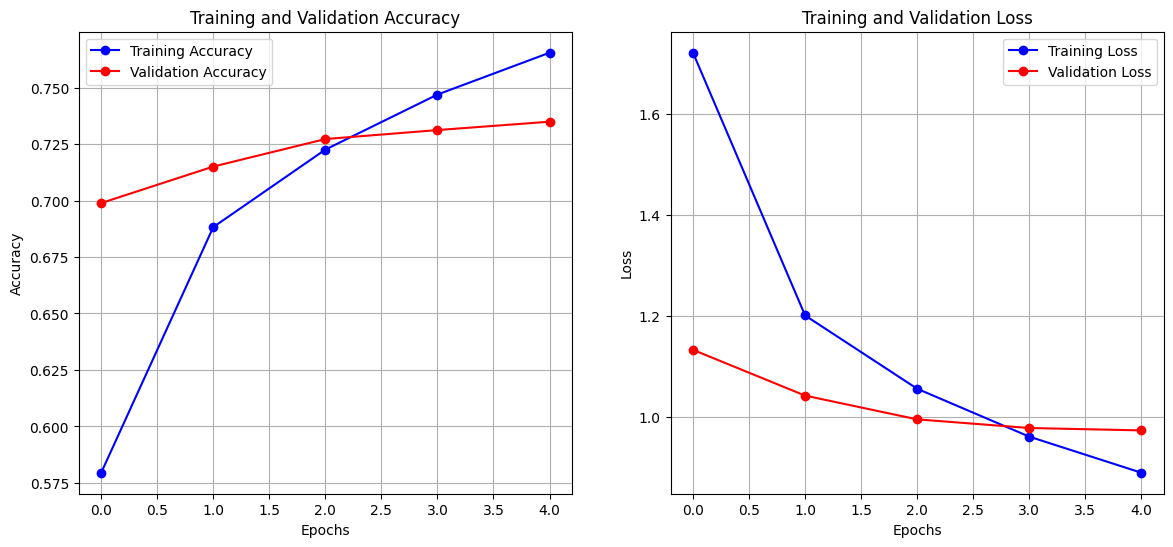

In [18]:
plot_history(history_model_0)

### model_1 construction and training

In [19]:
model_1 = build_model(model_name="model_1",
                      num_classes=len(class_names),
                      backbone=EfficientNetB0,
                      with_data_aug=True,
                      normalize=False,
                      add_bottleneck_layer=False,
                      with_regularization_and_dropout=False,
                      use_transfer_learning=True)
model_1.summary()

<Policy "mixed_float16">
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 logits_layer (Dense)        (None, 101)               129381    
                                                                 
 activation_output_layer (Ac  (Non

In [20]:
display_layers_info(model_1)


          Layer name: input_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float32'>
          Layer compute dtype: float32

    

          Layer name: data_augmentation_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: efficientnetb0
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: global_average_pooling_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: logits_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: activation_ou

In [21]:
history_model_1 = model_1.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=prepare_callbacks(checkpoint_name="feature_extraction_with_data_augmentation_model_1",
                                                          logs_name="feature_extraction_with_data_augmentation_model_1")
                              )

Epoch 1/5


2367/2368 [============================>.] - ETA: 0s - loss: 2.0843 - accuracy: 0.4981
Epoch 1: val_accuracy improved from -inf to 0.65042, saving model to ./checkpoints\feature_extraction_with_data_augmentation_model_1.weights.h5
2368/2368 [==============================] - 301s 125ms/step - loss: 2.0843 - accuracy: 0.4981 - val_loss: 1.2919 - val_accuracy: 0.6504 - lr: 0.0010
Epoch 2/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.5981 - accuracy: 0.5942
Epoch 2: val_accuracy improved from 0.65042 to 0.67479, saving model to ./checkpoints\feature_extraction_with_data_augmentation_model_1.weights.h5
2368/2368 [==============================] - 274s 116ms/step - loss: 1.5980 - accuracy: 0.5942 - val_loss: 1.1984 - val_accuracy: 0.6748 - lr: 0.0010
Epoch 3/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.4777 - accuracy: 0.6207
Epoch 3: val_accuracy improved from 0.67479 to 0.69253, saving model to ./checkpoints\feature_extraction_with_data_augmentation_

In [22]:
save_training_history(history_model_1, "model_1")

Training history saved to ./histories/json/model_1.json


In [45]:
model_1.load_weights("checkpoints/feature_extraction_with_data_augmentation_model_1.weights.h5")
result_model_1 = model_1.evaluate(test_data)
result_model_1

790/790 [==============================] - 17s 20ms/step - loss: 1.1347 - accuracy: 0.6896


[1.1346849203109741, 0.6896237730979919]

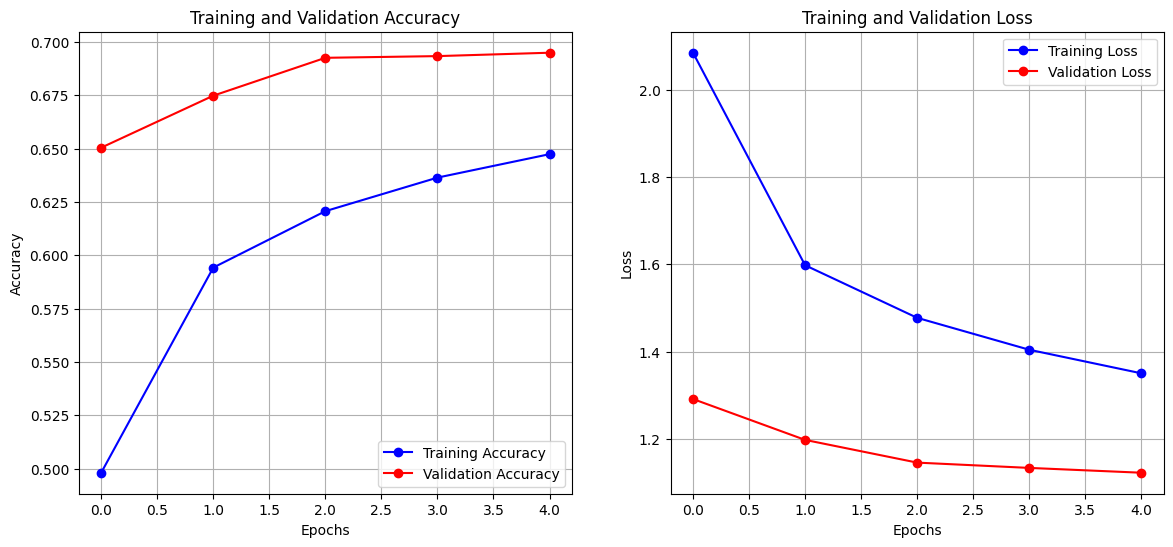

In [24]:
plot_history(history_model_1)

### Experiment 1: CONCLUSION


**Models Trained:**  
- **Model_0**: Without data augmentation  
  - Validation Accuracy: **73.2%**  
  - Validation Loss: **0.97**  
  - Training Time: **6 minutes**  
- **Model_1**: With data augmentation  
  - Validation Accuracy: **69.3%**  
  - Validation Loss: **1.12**  
  - Training Time: **20 minutes**  

**Conclusion:**  
Model_0 outperformed Model_1 in validation accuracy, validation loss, and training time.  
**Decision:** Data augmentation will be **excluded** from future experiments.  

---

## Experiment 2: Impact of Progressive Fine-Tuning on Model Accuracy  

**Objective:**  
Assess whether **progressive fine-tuning** (gradual unfreezing of layers) improves accuracy compared to training only for 5 epochs as a feature extractor.

**Model to be Trained:**  
- **Model_2**:  
  - **Phase 1**: Feature extraction (**5 epochs**)  
  - **Phase 2**: Fine-tuning (**15 additional epochs**)  
    - Unfreeze **last 5%** of layers → Train for **5 epochs**  
    - Unfreeze **last 10%** of layers → Train for **5 epochs**  
    - Unfreeze **last 15%** of layers → Train for **5 epochs**  
  - **Learning rate** reduced **by 10×** at each fine-tuning phase.  

**Evaluation Metrics:**  
- Validation Accuracy  
- Validation Loss  
- Training Time  
<!-- - Convergence Speed   -->

**Next Step:** Train Model_2 and analyze performance.

In [25]:
model_2 = build_model(model_name="model_2",
                      num_classes=len(class_names),
                      backbone=EfficientNetB0,
                      with_data_aug=False,
                      normalize=False,
                      add_bottleneck_layer=False,
                      with_regularization_and_dropout=False,
                      use_transfer_learning=True)
model_2.summary()

<Policy "mixed_float16">
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 logits_layer (Dense)        (None, 101)               129381    
                                                                 
 activation_output_layer (Ac  (None, 101)              0         
 tivation)                                                       
                                                                 
Total params: 4,178,952
Trainable 

In [26]:
history_model_2_feature_extraction = model_2.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=prepare_callbacks(checkpoint_name="feature_extraction_model_2",
                                                          logs_name="feature_extraction_model_2")
                              )

Epoch 1/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.7186 - accuracy: 0.5802
Epoch 1: val_accuracy improved from -inf to 0.69571, saving model to ./checkpoints\feature_extraction_model_2.weights.h5
2368/2368 [==============================] - 55s 22ms/step - loss: 1.7185 - accuracy: 0.5803 - val_loss: 1.1363 - val_accuracy: 0.6957 - lr: 0.0010
Epoch 2/5
2365/2368 [============================>.] - ETA: 0s - loss: 1.2014 - accuracy: 0.6887
Epoch 2: val_accuracy improved from 0.69571 to 0.71769, saving model to ./checkpoints\feature_extraction_model_2.weights.h5
2368/2368 [==============================] - 52s 22ms/step - loss: 1.2017 - accuracy: 0.6887 - val_loss: 1.0323 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 3/5
2365/2368 [============================>.] - ETA: 0s - loss: 1.0553 - accuracy: 0.7239
Epoch 3: val_accuracy improved from 0.71769 to 0.72934, saving model to ./checkpoints\feature_extraction_model_2.weights.h5
2368/2368 [==============================] -

In [27]:
save_training_history(history_model_2_feature_extraction, "model_2_feature_extraction")

Training history saved to ./histories/json/model_2_feature_extraction.json


In [28]:
result_model_2_feature_extraction = model_2.evaluate(test_data)
result_model_2_feature_extraction

790/790 [==============================] - 15s 19ms/step - loss: 0.9539 - accuracy: 0.7394


[0.9538733959197998, 0.7394455671310425]

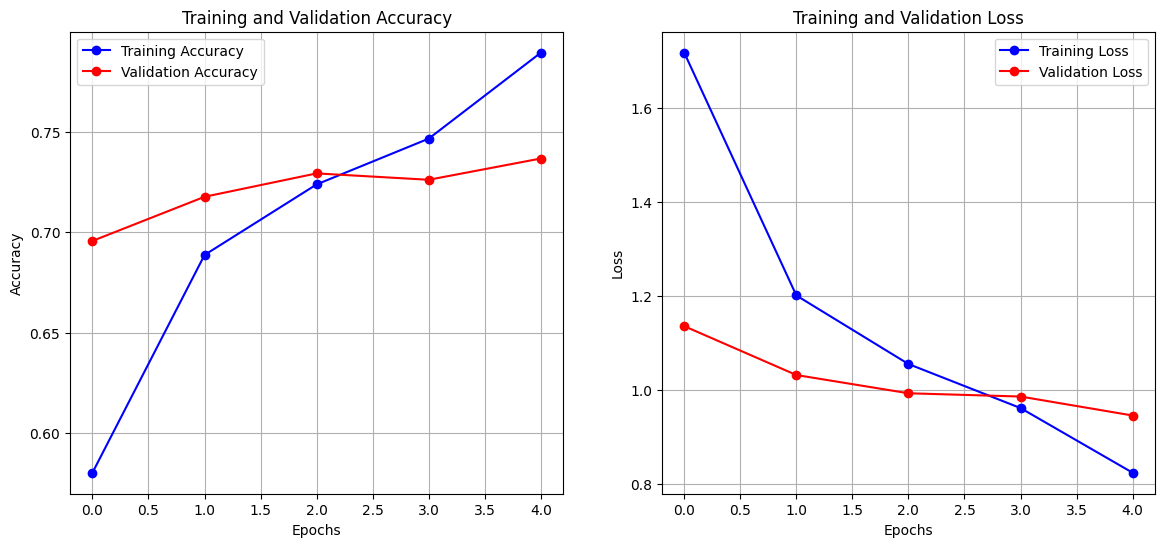

In [29]:
plot_history(history_model_2_feature_extraction)

In [30]:
model_2 = unfreeze_top_layers(model_2, start_fraction=0.95, learning_rate=0.0001)


In [31]:
for layer in model_2.layers[1].layers:
    print(layer.name, "\t", layer.trainable)

input_3 	 False
rescaling_4 	 False
normalization_2 	 False
rescaling_5 	 False
stem_conv_pad 	 False
stem_conv 	 False
stem_bn 	 False
stem_activation 	 False
block1a_dwconv 	 False
block1a_bn 	 False
block1a_activation 	 False
block1a_se_squeeze 	 False
block1a_se_reshape 	 False
block1a_se_reduce 	 False
block1a_se_expand 	 False
block1a_se_excite 	 False
block1a_project_conv 	 False
block1a_project_bn 	 False
block2a_expand_conv 	 False
block2a_expand_bn 	 False
block2a_expand_activation 	 False
block2a_dwconv_pad 	 False
block2a_dwconv 	 False
block2a_bn 	 False
block2a_activation 	 False
block2a_se_squeeze 	 False
block2a_se_reshape 	 False
block2a_se_reduce 	 False
block2a_se_expand 	 False
block2a_se_excite 	 False
block2a_project_conv 	 False
block2a_project_bn 	 False
block2b_expand_conv 	 False
block2b_expand_bn 	 False
block2b_expand_activation 	 False
block2b_dwconv 	 False
block2b_bn 	 False
block2b_activation 	 False
block2b_se_squeeze 	 False
block2b_se_reshape 	 False


In [32]:
history_model_2_fine_tune_5_percent = model_2.fit(train_data,
                              epochs=10,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=prepare_callbacks(checkpoint_name="fine_tune_5_percent_model_2",
                                                          logs_name="fine_tune_5_percent_model_2"),
                              initial_epoch=5
                              )

Epoch 6/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.7962 - accuracy: 0.7980
Epoch 6: val_accuracy improved from -inf to 0.73914, saving model to ./checkpoints\fine_tune_5_percent_model_2.weights.h5
2368/2368 [==============================] - 55s 22ms/step - loss: 0.7962 - accuracy: 0.7980 - val_loss: 0.9418 - val_accuracy: 0.7391 - lr: 1.0000e-04
Epoch 7/10
2368/2368 [==============================] - ETA: 0s - loss: 0.7882 - accuracy: 0.8006
Epoch 7: val_accuracy improved from 0.73914 to 0.73994, saving model to ./checkpoints\fine_tune_5_percent_model_2.weights.h5
2368/2368 [==============================] - 52s 22ms/step - loss: 0.7882 - accuracy: 0.8006 - val_loss: 0.9406 - val_accuracy: 0.7399 - lr: 1.0000e-04
Epoch 8/10
2365/2368 [============================>.] - ETA: 0s - loss: 0.7812 - accuracy: 0.8025
Epoch 8: val_accuracy improved from 0.73994 to 0.74073, saving model to ./checkpoints\fine_tune_5_percent_model_2.weights.h5
2368/2368 [===================

In [33]:
save_training_history(history_model_2_fine_tune_5_percent, "model_2_fine_tune_5_percent")

Training history saved to ./histories/json/model_2_fine_tune_5_percent.json


In [34]:
result_model_2_fine_tune_5_percent = model_2.evaluate(test_data)
result_model_2_fine_tune_5_percent

790/790 [==============================] - 15s 20ms/step - loss: 0.9457 - accuracy: 0.7417


[0.9456570744514465, 0.7416633367538452]

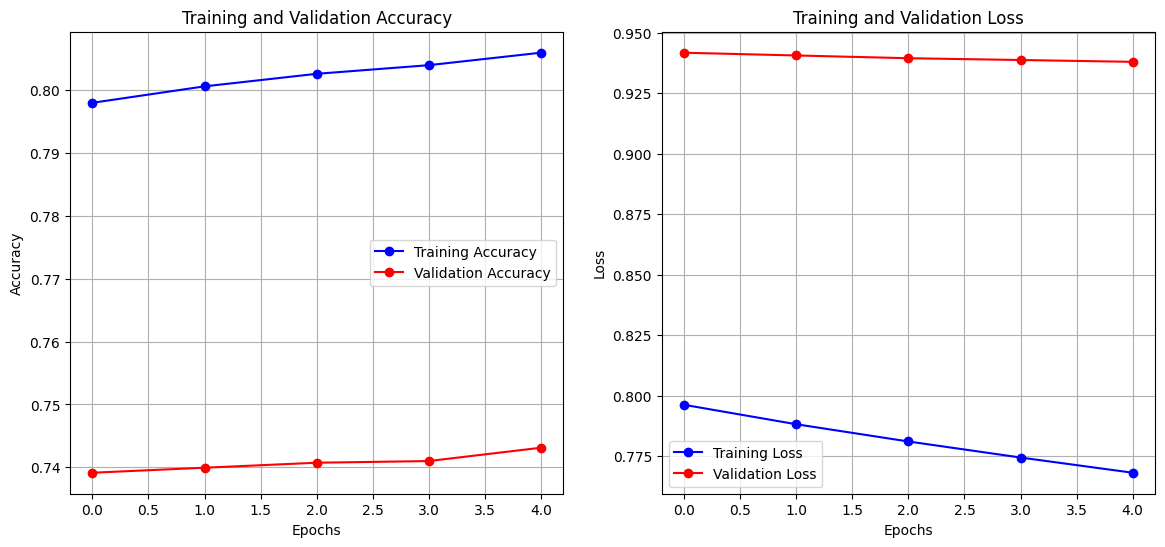

In [35]:
plot_history(history_model_2_fine_tune_5_percent)

In [36]:
model_2 = unfreeze_top_layers(model_2, start_fraction=0.9, learning_rate=0.00001)


In [37]:
for layer in model_2.layers[1].layers:
    print(layer.name, "\t", layer.trainable)

input_3 	 False
rescaling_4 	 False
normalization_2 	 False
rescaling_5 	 False
stem_conv_pad 	 False
stem_conv 	 False
stem_bn 	 False
stem_activation 	 False
block1a_dwconv 	 False
block1a_bn 	 False
block1a_activation 	 False
block1a_se_squeeze 	 False
block1a_se_reshape 	 False
block1a_se_reduce 	 False
block1a_se_expand 	 False
block1a_se_excite 	 False
block1a_project_conv 	 False
block1a_project_bn 	 False
block2a_expand_conv 	 False
block2a_expand_bn 	 False
block2a_expand_activation 	 False
block2a_dwconv_pad 	 False
block2a_dwconv 	 False
block2a_bn 	 False
block2a_activation 	 False
block2a_se_squeeze 	 False
block2a_se_reshape 	 False
block2a_se_reduce 	 False
block2a_se_expand 	 False
block2a_se_excite 	 False
block2a_project_conv 	 False
block2a_project_bn 	 False
block2b_expand_conv 	 False
block2b_expand_bn 	 False
block2b_expand_activation 	 False
block2b_dwconv 	 False
block2b_bn 	 False
block2b_activation 	 False
block2b_se_squeeze 	 False
block2b_se_reshape 	 False


In [38]:
history_model_2_fine_tune_10_percent = model_2.fit(train_data, 
                              epochs=15,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=prepare_callbacks(checkpoint_name="fine_tune_10_percent_model_2",
                                                          logs_name="fine_tune_10_percent_model_2"),
                              initial_epoch=10
                              )

Epoch 11/15
2366/2368 [============================>.] - ETA: 0s - loss: 0.7529 - accuracy: 0.8104
Epoch 11: val_accuracy improved from -inf to 0.74285, saving model to ./checkpoints\fine_tune_10_percent_model_2.weights.h5
2368/2368 [==============================] - 59s 24ms/step - loss: 0.7531 - accuracy: 0.8104 - val_loss: 0.9369 - val_accuracy: 0.7428 - lr: 1.0000e-05
Epoch 12/15
2367/2368 [============================>.] - ETA: 0s - loss: 0.7518 - accuracy: 0.8111
Epoch 12: val_accuracy improved from 0.74285 to 0.74444, saving model to ./checkpoints\fine_tune_10_percent_model_2.weights.h5
2368/2368 [==============================] - 56s 23ms/step - loss: 0.7518 - accuracy: 0.8111 - val_loss: 0.9367 - val_accuracy: 0.7444 - lr: 1.0000e-05
Epoch 13/15
2366/2368 [============================>.] - ETA: 0s - loss: 0.7510 - accuracy: 0.8115
Epoch 13: val_accuracy did not improve from 0.74444

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
2368/2368 [======

In [39]:
save_training_history(history_model_2_fine_tune_10_percent, "model_2_fine_tune_10_percent")

Training history saved to ./histories/json/model_2_fine_tune_10_percent.json


In [40]:
result_model_2_fine_tune_10_percent = model_2.evaluate(test_data)
result_model_2_fine_tune_10_percent

790/790 [==============================] - 15s 20ms/step - loss: 0.9431 - accuracy: 0.7421


[0.9430878162384033, 0.7420594096183777]

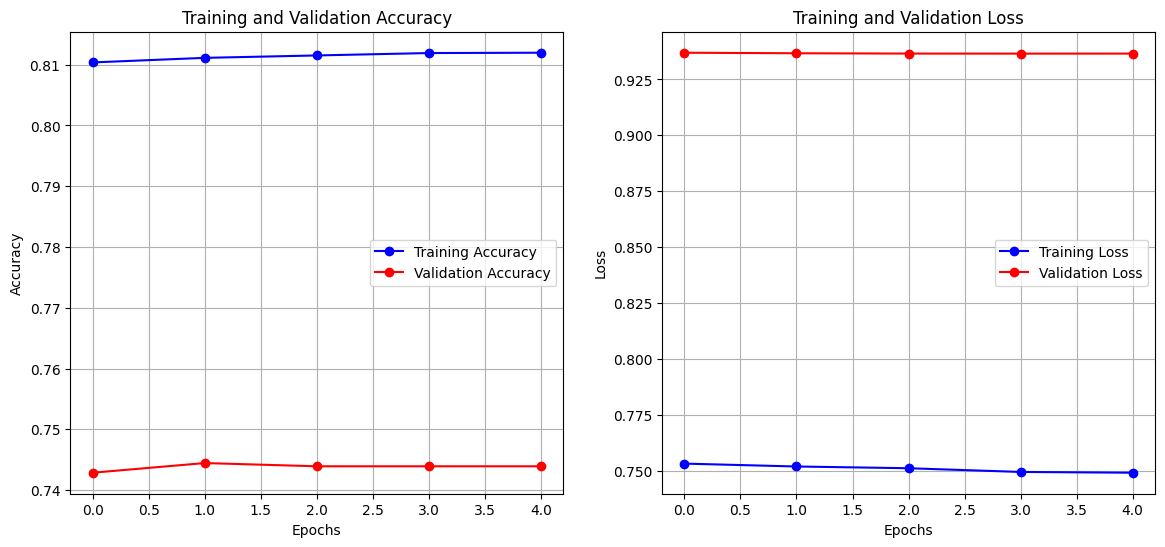

In [41]:
plot_history(history_model_2_fine_tune_10_percent)

In [42]:
model_2 = unfreeze_top_layers(model_2, start_fraction=0.85, learning_rate=0.000001)

In [43]:
for layer in model_2.layers[1].layers:
    print(layer.name, "\t", layer.trainable)

input_3 	 False
rescaling_4 	 False
normalization_2 	 False
rescaling_5 	 False
stem_conv_pad 	 False
stem_conv 	 False
stem_bn 	 False
stem_activation 	 False
block1a_dwconv 	 False
block1a_bn 	 False
block1a_activation 	 False
block1a_se_squeeze 	 False
block1a_se_reshape 	 False
block1a_se_reduce 	 False
block1a_se_expand 	 False
block1a_se_excite 	 False
block1a_project_conv 	 False
block1a_project_bn 	 False
block2a_expand_conv 	 False
block2a_expand_bn 	 False
block2a_expand_activation 	 False
block2a_dwconv_pad 	 False
block2a_dwconv 	 False
block2a_bn 	 False
block2a_activation 	 False
block2a_se_squeeze 	 False
block2a_se_reshape 	 False
block2a_se_reduce 	 False
block2a_se_expand 	 False
block2a_se_excite 	 False
block2a_project_conv 	 False
block2a_project_bn 	 False
block2b_expand_conv 	 False
block2b_expand_bn 	 False
block2b_expand_activation 	 False
block2b_dwconv 	 False
block2b_bn 	 False
block2b_activation 	 False
block2b_se_squeeze 	 False
block2b_se_reshape 	 False


In [44]:
history_model_2_fine_tune_15_percent = model_2.fit(train_data, 
                              epochs=20,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=prepare_callbacks(checkpoint_name="fine_tune_15_percent_model_2",
                                                          logs_name="fine_tune_15_percent_model_2"),
                              initial_epoch=15
                              )

Epoch 16/20
2368/2368 [==============================] - ETA: 0s - loss: 0.7491 - accuracy: 0.8120
Epoch 16: val_accuracy improved from -inf to 0.74391, saving model to ./checkpoints\fine_tune_15_percent_model_2.weights.h5
2368/2368 [==============================] - 59s 24ms/step - loss: 0.7491 - accuracy: 0.8120 - val_loss: 0.9365 - val_accuracy: 0.7439 - lr: 1.0000e-06
Epoch 17/20
2368/2368 [==============================] - ETA: 0s - loss: 0.7490 - accuracy: 0.8121
Epoch 17: val_accuracy did not improve from 0.74391

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.9999999949504855e-07.
2368/2368 [==============================] - 56s 24ms/step - loss: 0.7490 - accuracy: 0.8121 - val_loss: 0.9365 - val_accuracy: 0.7436 - lr: 1.0000e-06
Epoch 18/20
2366/2368 [============================>.] - ETA: 0s - loss: 0.7488 - accuracy: 0.8122
Epoch 18: val_accuracy did not improve from 0.74391

Epoch 18: ReduceLROnPlateau reducing learning rate to 1e-07.
2368/2368 [===================

In [45]:
save_training_history(history_model_2_fine_tune_15_percent, "model_2_fine_tune_15_percent")

Training history saved to ./histories/json/model_2_fine_tune_15_percent.json


In [46]:
result_model_2_fine_tune_15_percent = model_2.evaluate(test_data)
result_model_2_fine_tune_15_percent

790/790 [==============================] - 15s 20ms/step - loss: 0.9430 - accuracy: 0.7421


[0.9430402517318726, 0.7420594096183777]

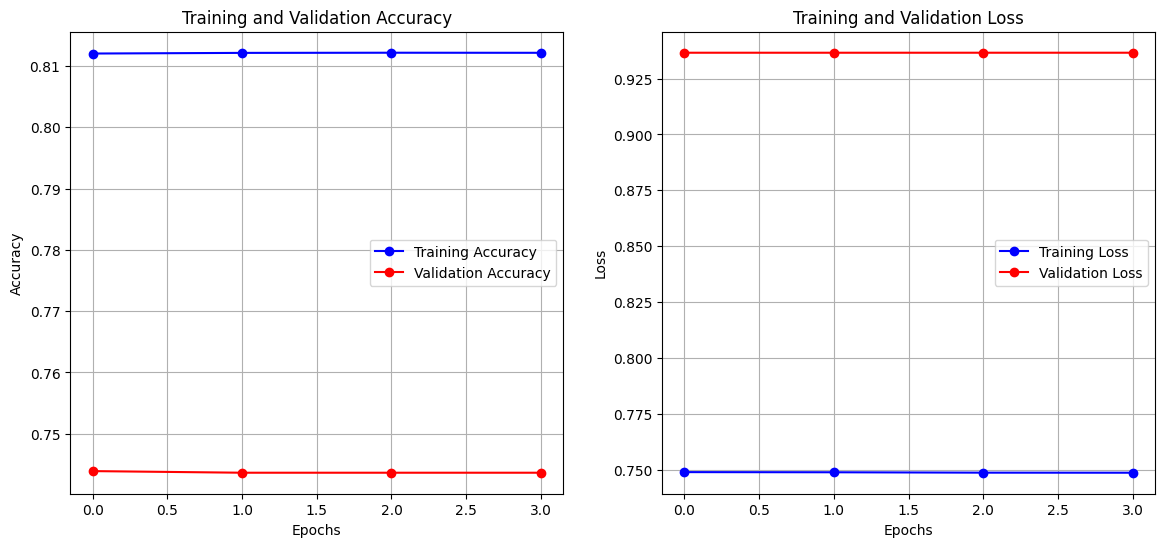

In [47]:
plot_history(history_model_2_fine_tune_15_percent)

### Experiment 2: Conclusion  

**Model_2** started as a **feature extractor**, similar to **Model_0**, achieving almost identical performance.  

After applying **progressive fine-tuning** over **15 additional epochs**:  
- **Phase 1:** Unfroze **last 5%** of layers → Trained for **5 epochs**  
- **Phase 2:** Unfroze **last 10%** of layers → Trained for **5 epochs**  
- **Phase 3:** Unfroze **last 15%** of layers → Trained for **5 epochs**  

**Key Findings:**  
✅ Validation accuracy **improved by 1.5%**  
❌ **Significant overfitting** observed compared to feature extraction (Model_2/Model_0)  
❌ Model struggles to **generalize** and may not perform well on unseen data  

**Conclusion:**
<br>Fine-tuning **in its current form** did not provide a meaningful performance boost.  
However, **fine-tuning is not excluded** from future experiments. It will be **retested** with **regularization** and **dropout** to mitigate overfitting.  


## Experiment 3: Training from Scratch  

In this experiment, we test whether **training the entire model from scratch** outperforms **transfer learning**.  

**Model_3 Setup:**  
- **Feature extraction:** Trained for **5 epochs**  
- **No data augmentation** (consistent with previous models)  
- **Backbone architecture remains the same**  
- **No pre-trained weights** → Entire network is trained **from scratch**  

**Objective:**<br>
Compare the performance of **Model_3** (trained from scratch) against **Model_0** and **Model_2**, which utilized **transfer learning** with pre-trained weights.<br>
This experiment aims to determine whether leveraging **pre-trained knowledge** leads to superior results compared to learning everything from our dataset alone.  

In [48]:
model_3 = build_model(model_name="model_3",
                      num_classes=len(class_names),
                      backbone=EfficientNetB0,
                      with_data_aug=False,
                      normalize=False,
                      add_bottleneck_layer=False,
                      with_regularization_and_dropout=False,
                      use_transfer_learning=False)

model_3.summary()

<Policy "mixed_float16">
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 logits_layer (Dense)        (None, 101)               129381    
                                                                 
 activation_output_layer (Ac  (None, 101)              0         
 tivation)                                                       
                                                                 
Total params: 4,178,952
Trainable 

In [49]:
display_layers_info(model_3)


          Layer name: input_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float32'>
          Layer compute dtype: float32

    

          Layer name: efficientnetb0
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: global_average_pooling_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: logits_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: activation_output_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float32'>
          Layer compute dtype: float32

    


In [50]:
for layer in model_3.layers[1].layers:
    print(layer.name, "\t", layer.trainable)

input_4 	 True
rescaling_6 	 True
normalization_3 	 True
rescaling_7 	 True
stem_conv_pad 	 True
stem_conv 	 True
stem_bn 	 True
stem_activation 	 True
block1a_dwconv 	 True
block1a_bn 	 True
block1a_activation 	 True
block1a_se_squeeze 	 True
block1a_se_reshape 	 True
block1a_se_reduce 	 True
block1a_se_expand 	 True
block1a_se_excite 	 True
block1a_project_conv 	 True
block1a_project_bn 	 True
block2a_expand_conv 	 True
block2a_expand_bn 	 True
block2a_expand_activation 	 True
block2a_dwconv_pad 	 True
block2a_dwconv 	 True
block2a_bn 	 True
block2a_activation 	 True
block2a_se_squeeze 	 True
block2a_se_reshape 	 True
block2a_se_reduce 	 True
block2a_se_expand 	 True
block2a_se_excite 	 True
block2a_project_conv 	 True
block2a_project_bn 	 True
block2b_expand_conv 	 True
block2b_expand_bn 	 True
block2b_expand_activation 	 True
block2b_dwconv 	 True
block2b_bn 	 True
block2b_activation 	 True
block2b_se_squeeze 	 True
block2b_se_reshape 	 True
block2b_se_reduce 	 True
block2b_se_expa

In [51]:
history_model_3 = model_3.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=prepare_callbacks(checkpoint_name="model_3_without_transfer_learning",
                                                          logs_name="model_3_without_transfer_learning")
                              )

Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.6543 - accuracy: 0.5796
Epoch 1: val_accuracy improved from -inf to 0.71743, saving model to ./checkpoints\model_3_without_transfer_learning.weights.h5
2368/2368 [==============================] - 515s 215ms/step - loss: 1.6543 - accuracy: 0.5796 - val_loss: 1.0223 - val_accuracy: 0.7174 - lr: 0.0010
Epoch 2/5
2368/2368 [==============================] - ETA: 0s - loss: 1.0741 - accuracy: 0.7124
Epoch 2: val_accuracy improved from 0.71743 to 0.72855, saving model to ./checkpoints\model_3_without_transfer_learning.weights.h5
2368/2368 [==============================] - 508s 214ms/step - loss: 1.0741 - accuracy: 0.7124 - val_loss: 0.9661 - val_accuracy: 0.7285 - lr: 0.0010
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 0.8627 - accuracy: 0.7622
Epoch 3: val_accuracy improved from 0.72855 to 0.74391, saving model to ./checkpoints\model_3_without_transfer_learning.weights.h5
2368/2368 [========

In [52]:
save_training_history(history_model_3, "model_3")

Training history saved to ./histories/json/model_3.json


In [53]:
result_model_3 = model_3.evaluate(test_data)
result_model_3

790/790 [==============================] - 18s 23ms/step - loss: 0.9559 - accuracy: 0.7496


[0.9559110999107361, 0.7495841383934021]

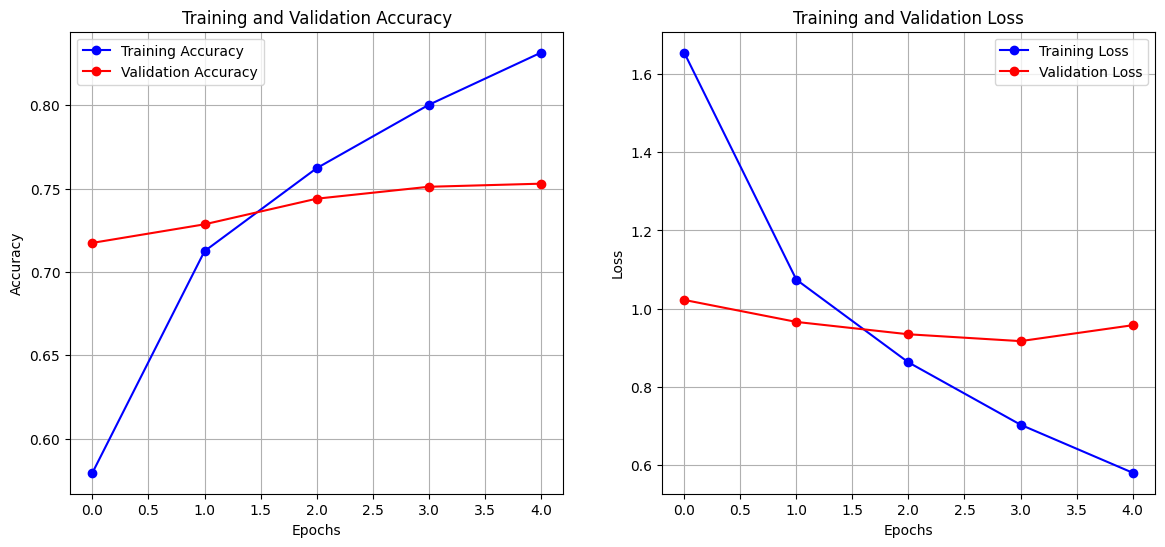

In [57]:
plot_history(history_model_3)

In [54]:
result_model_0, result_model_1, result_model_2_feature_extraction, result_model_2_fine_tune_5_percent, result_model_2_fine_tune_10_percent, result_model_2_fine_tune_15_percent, result_model_3

([0.9840071797370911, 0.7312871217727661],
 [1.1346849203109741, 0.6896237730979919],
 [0.9538733959197998, 0.7394455671310425],
 [0.9456570744514465, 0.7416633367538452],
 [0.9430878162384033, 0.7420594096183777],
 [0.9430402517318726, 0.7420594096183777],
 [0.9559110999107361, 0.7495841383934021])

### **Experiment 3 Conclusion**

In this experiment, **model_3** was trained using the same architecture as **model_0** and **model_2** (feature extraction),<br> but with a key difference: the backbone weights were **not frozen** (i.e., no transfer learning was used).<br> Instead, the entire architecture was trained from scratch for **5 epochs**.

**Results:**
- **Validation Accuracy:** **75%**  
- **Validation Loss:** **0.955**  
- This represents a **clear accuracy boost of 2%** compared to using pretrained backbone weights in model_2 withouth introducing huge overfitting compared to fine-tuned models.

Additionally, analyzing the loss curves of both **model_2 (feature extraction)** and **model_3 (full training)** suggests that training for **more epochs with lower learning rates** could further improve accuracy. However, since training **from scratch already outperformed transfer learning by 2%**, transfer learning will be **eliminated** from later experiments.


## Experiment 4: Effect of Regularization and Dropout
Objective:
Investigate the impact of adding L2 regularization (on the output dense layer) and an extra dropout layer (after the global average pooling layer and before the logits layer).

Model to be Trained:

Model_4

Same architecture as Model_3

L2 regularization added to the output dense layer

Dropout layer added before the final classification layer

Key Difference from Model_3:
The only change in Model_4 compared to Model_3 is the addition of regularization and dropout to test their effect on model performance.

In [12]:
model_4 = build_model(model_name="model_4",
                      num_classes=len(class_names),
                      backbone=EfficientNetB0,
                      with_data_aug=False,
                      normalize=False,
                      add_bottleneck_layer=False,
                      with_regularization_and_dropout=True,
                      use_transfer_learning=False)
model_4.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070 Ti, compute capability 12.0


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070 Ti, compute capability 12.0


<Policy "mixed_float16">
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 logits_layer (Dense)        (None, 101)               129381    
                                                                 
 activation_output_layer (Ac  (None, 101)              0         
 tivation)                        

In [16]:
display_layers_info(model_4)


          Layer name: input_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float32'>
          Layer compute dtype: float32

    

          Layer name: efficientnetb0
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: global_average_pooling_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: dropout
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: logits_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: activation_output_layer
      

In [33]:
history_model_4 = model_4.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=prepare_callbacks(checkpoint_name="model_4_with_regularization_and_dropout",
                                                          logs_name="model_4_with_regularization_and_dropout")
                              )

Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.9658 - accuracy: 0.5551
Epoch 1: val_accuracy improved from -inf to 0.69544, saving model to ./checkpoints\model_4_with_regularization_and_dropout.weights.h5
2368/2368 [==============================] - 617s 217ms/step - loss: 1.9658 - accuracy: 0.5551 - val_loss: 1.2967 - val_accuracy: 0.6954 - lr: 0.0010
Epoch 2/5
2368/2368 [==============================] - ETA: 0s - loss: 1.3754 - accuracy: 0.6835
Epoch 2: val_accuracy improved from 0.69544 to 0.73861, saving model to ./checkpoints\model_4_with_regularization_and_dropout.weights.h5
2368/2368 [==============================] - 508s 215ms/step - loss: 1.3754 - accuracy: 0.6835 - val_loss: 1.1581 - val_accuracy: 0.7386 - lr: 0.0010
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 1.1747 - accuracy: 0.7311
Epoch 3: val_accuracy did not improve from 0.73861

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368

In [34]:
save_training_history(history_model_4, "model_4")

Training history saved to ./histories/json/model_4.json


In [35]:
result_model_4 = model_4.evaluate(test_data)
result_model_4

790/790 [==============================] - 18s 23ms/step - loss: 0.8507 - accuracy: 0.8023


[0.8506719470024109, 0.8023366332054138]

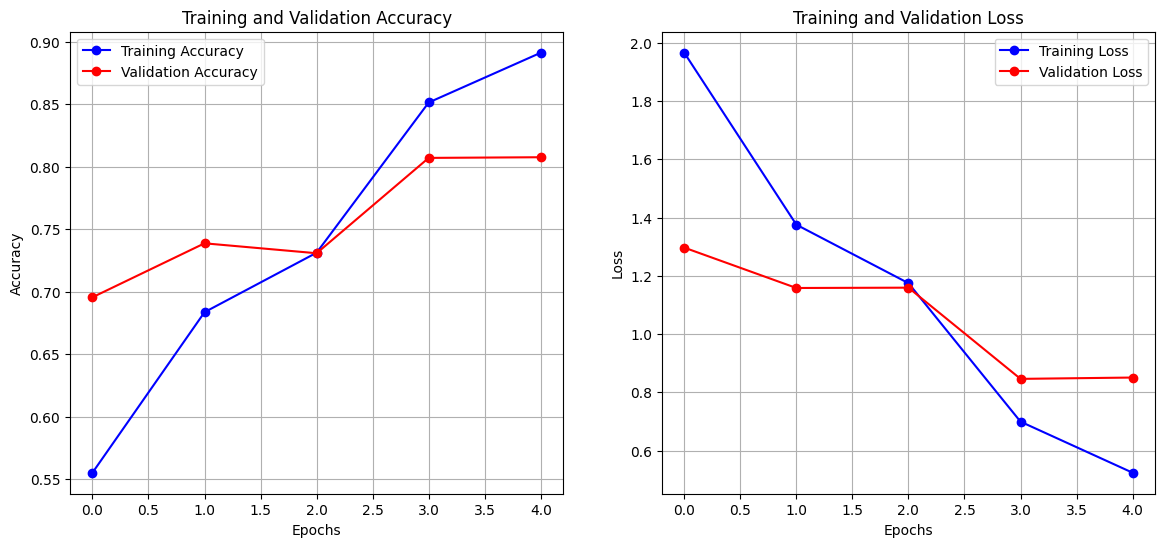

In [36]:
plot_history(history_model_4)

### Experiment 4: Conclusion
Model_4 achieved the highest validation accuracy so far, showing a 5% improvement compared to the previous best model (Model_3: 75%).

Additionally:
✅ Validation loss was lower than previous models.
✅ Loss curves indicated a better fitting behavior compared to Model_3 (less overfitting).

Conclusion:
The addition of regularization and dropout significantly improved performance. Therefore, these techniques will be included in the final model architecture.

## Experiment 5: Effect of Adding a Bottleneck Layer
Objective:
Evaluate the impact of adding an additional dense (bottleneck) layer to the architecture. This experiment aims to test whether increasing model complexity by introducing an extra dense layer improves performance.

Model to be Trained:

Model_5

Same architecture as Model_4

One additional dense (bottleneck) layer added before the output layer

The bottleneck layer will include L2 regularization

Key Difference from Model_4:
The only modification is the addition of a bottleneck layer to analyze whether extra complexity benefits performance.

In [12]:
model_5 = build_model(model_name="model_5",
                      num_classes=len(class_names),
                      backbone=EfficientNetB0,
                      with_data_aug=False,
                      normalize=False,
                      add_bottleneck_layer=True,
                      with_regularization_and_dropout=True,
                      use_transfer_learning=False)
model_5.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070 Ti, compute capability 12.0


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070 Ti, compute capability 12.0


<Policy "mixed_float16">
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 bottleneck_layer (Dense)    (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                  

In [13]:
display_layers_info(model_5)


          Layer name: input_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float32'>
          Layer compute dtype: float32

    

          Layer name: efficientnetb0
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: global_average_pooling_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: dropout
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: bottleneck_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: dropout_1
          Traina

In [14]:
history_model_5 = model_5.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=prepare_callbacks(checkpoint_name="model_5_with_bottleneck_layer",
                                                          logs_name="model_5_with_bottleneck_layer")
                              )

Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 2.5735 - accuracy: 0.4763
Epoch 1: val_accuracy improved from -inf to 0.66949, saving model to ./checkpoints\model_5_with_bottleneck_layer.weights.h5
2368/2368 [==============================] - 781s 218ms/step - loss: 2.5735 - accuracy: 0.4763 - val_loss: 1.6220 - val_accuracy: 0.6695 - lr: 0.0010
Epoch 2/5
2368/2368 [==============================] - ETA: 0s - loss: 1.7908 - accuracy: 0.6283
Epoch 2: val_accuracy improved from 0.66949 to 0.69465, saving model to ./checkpoints\model_5_with_bottleneck_layer.weights.h5
2368/2368 [==============================] - 514s 217ms/step - loss: 1.7908 - accuracy: 0.6283 - val_loss: 1.4673 - val_accuracy: 0.6947 - lr: 0.0010
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 1.5475 - accuracy: 0.6804
Epoch 3: val_accuracy improved from 0.69465 to 0.71901, saving model to ./checkpoints\model_5_with_bottleneck_layer.weights.h5
2368/2368 [====================

In [15]:
save_training_history(history_model_5, "model_5")

Training history saved to ./histories/json/model_5.json


In [16]:
result_model_5 = model_5.evaluate(test_data)
result_model_5

790/790 [==============================] - 19s 24ms/step - loss: 1.3303 - accuracy: 0.7289


[1.3303197622299194, 0.7288712859153748]

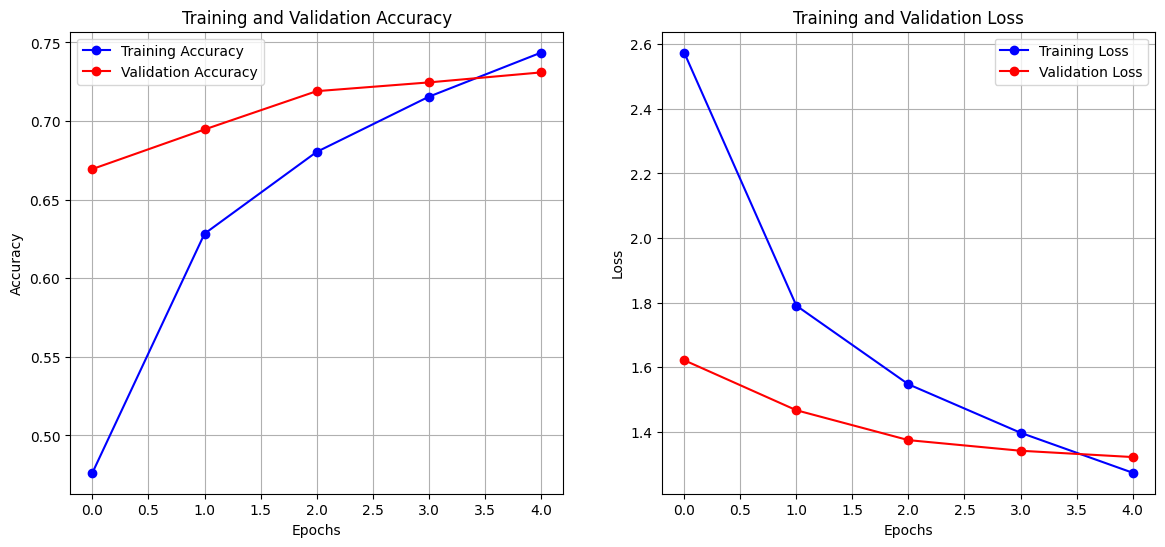

In [17]:
plot_history(history_model_5)

### Experiment 5: Conclusion
Model_5 achieved a validation accuracy of 73%, which is lower than both Model_4 (80%) and Model_3 (75%).

Key Observations:
✅ Loss curves indicated a good fit, suggesting that with more training epochs, Model_5 could potentially improve its performance.
❌ However, Model_4 converged faster and achieved a higher validation accuracy (80%) without the additional bottleneck layer.
❌ The extra bottleneck layer did not provide any immediate performance benefits and instead led to a decrease in accuracy.

Conclusion:
Although training for more epochs could improve Model_5’s accuracy, Model_4 demonstrated faster convergence and better performance without the additional dense layer.
As a result, increasing the architecture’s complexity by adding a bottleneck layer will be eliminated from future experiments.

### **Experiment 6: Impact of Progressive Fine-Tuning on Model Performance**  

**Objective:**  
Investigate whether **progressive fine-tuning** enhances model performance compared to training all layers from the beginning.  

**Model to be Trained:**  
- **Model_6** (same architecture as **Model_4**)  
- **Training Phases:**  
  - **Phase 1:** Train **entire model** (all layers) for **5 epochs**  
  - **Phase 2:** Freeze all layers → Unfreeze **last 5%** → Train for **5 epochs** (**10× lower learning rate**)  
  - **Phase 3:** Unfreeze **last 10%** → Train for **5 epochs** (**10× lower learning rate**)  
  - **Phase 4:** Unfreeze **last 15%** → Train for **5 epochs** (**10× lower learning rate**)  

**Key Differences from Previous Experiments:**  
- **Same architecture as Model_4**, but trained with **progressive fine-tuning** instead of standard training.  
- Training was extended to **20 epochs** (compared to **5 epochs** in previous experiments).  

**Next Step:** Train Model_6 and analyze its performance.


In [12]:
model_6 = build_model(model_name="model_6",
                      num_classes=len(class_names),
                      backbone=EfficientNetB0,
                      with_data_aug=False,
                      normalize=False,
                      add_bottleneck_layer=False,
                      with_regularization_and_dropout=True,
                      use_transfer_learning=False)

model_6.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070 Ti, compute capability 12.0


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070 Ti, compute capability 12.0


<Policy "mixed_float16">
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 logits_layer (Dense)        (None, 101)               129381    
                                                                 
 activation_output_layer (Ac  (None, 101)              0         
 tivation)                        

In [17]:
display_layers_info(model_6)


          Layer name: input_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float32'>
          Layer compute dtype: float32

    

          Layer name: efficientnetb0
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: global_average_pooling_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: dropout
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: logits_layer
          Trainable: True
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: activation_output_layer
      

In [18]:
for layer in model_6.layers[1].layers:
    print(layer.name, "\t", layer.trainable)

input_1 	 True
rescaling 	 True
normalization 	 True
rescaling_1 	 True
stem_conv_pad 	 True
stem_conv 	 True
stem_bn 	 True
stem_activation 	 True
block1a_dwconv 	 True
block1a_bn 	 True
block1a_activation 	 True
block1a_se_squeeze 	 True
block1a_se_reshape 	 True
block1a_se_reduce 	 True
block1a_se_expand 	 True
block1a_se_excite 	 True
block1a_project_conv 	 True
block1a_project_bn 	 True
block2a_expand_conv 	 True
block2a_expand_bn 	 True
block2a_expand_activation 	 True
block2a_dwconv_pad 	 True
block2a_dwconv 	 True
block2a_bn 	 True
block2a_activation 	 True
block2a_se_squeeze 	 True
block2a_se_reshape 	 True
block2a_se_reduce 	 True
block2a_se_expand 	 True
block2a_se_excite 	 True
block2a_project_conv 	 True
block2a_project_bn 	 True
block2b_expand_conv 	 True
block2b_expand_bn 	 True
block2b_expand_activation 	 True
block2b_dwconv 	 True
block2b_bn 	 True
block2b_activation 	 True
block2b_se_squeeze 	 True
block2b_se_reshape 	 True
block2b_se_reduce 	 True
block2b_se_expand 	

In [13]:
history_model_6 = model_6.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=prepare_callbacks(checkpoint_name="model_6_with_regularization_and_dropout_feature_extraction",
                                                          logs_name="model_6_with_regularization_and_dropout_feature_extraction")
                              )

Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.9727 - accuracy: 0.5552
Epoch 1: val_accuracy improved from -inf to 0.69518, saving model to ./checkpoints\model_6_with_regularization_and_dropout_feature_extraction.weights.h5
2368/2368 [==============================] - 1025s 218ms/step - loss: 1.9727 - accuracy: 0.5552 - val_loss: 1.3271 - val_accuracy: 0.6952 - lr: 0.0010
Epoch 2/5
2368/2368 [==============================] - ETA: 0s - loss: 1.3705 - accuracy: 0.6869
Epoch 2: val_accuracy improved from 0.69518 to 0.72987, saving model to ./checkpoints\model_6_with_regularization_and_dropout_feature_extraction.weights.h5
2368/2368 [==============================] - 509s 215ms/step - loss: 1.3705 - accuracy: 0.6869 - val_loss: 1.1643 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 1.1664 - accuracy: 0.7318
Epoch 3: val_accuracy improved from 0.72987 to 0.74470, saving model to ./checkpoints\model_6_with_

In [14]:
save_training_history(history_model_6, "model_6_feature_extraction")

Training history saved to ./histories/json/model_6_feature_extraction.json


In [15]:
model_6.load_weights("checkpoints/model_6_with_regularization_and_dropout_feature_extraction.weights.h5")
result_model_6 = model_6.evaluate(test_data)
result_model_6

790/790 [==============================] - 18s 23ms/step - loss: 0.8535 - accuracy: 0.8057


[0.8535035848617554, 0.8057029843330383]

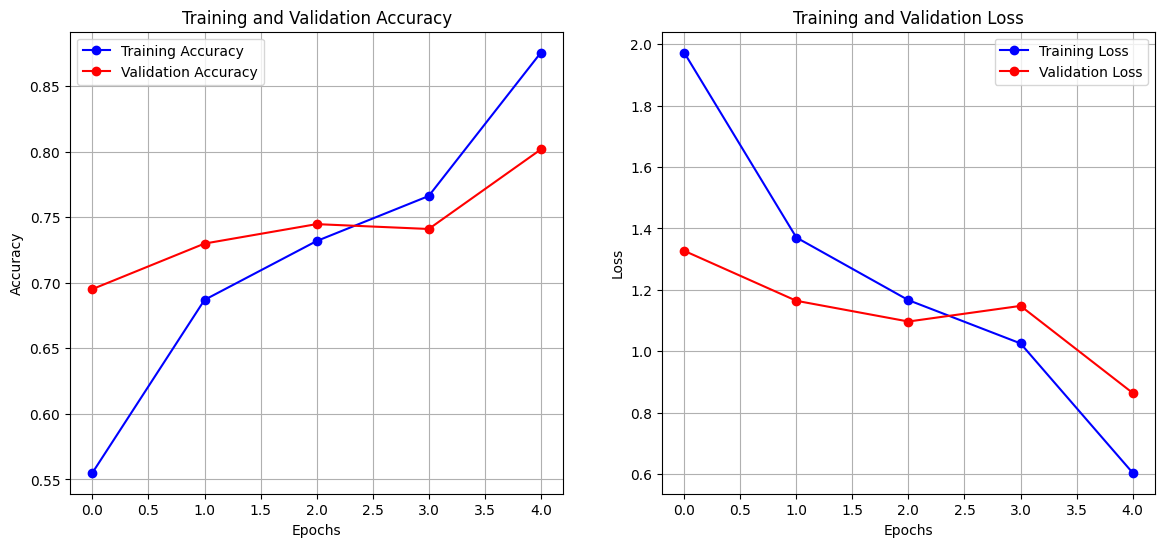

In [16]:
plot_history(history_model_6)

step 2

In [19]:
for layer in model_6.layers[1].layers:
    layer.trainable = False

for layer in model_6.layers:
    layer.trainable = False

In [20]:
display_layers_info(model_6)


          Layer name: input_layer
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float32'>
          Layer compute dtype: float32

    

          Layer name: efficientnetb0
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: global_average_pooling_layer
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: dropout
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: logits_layer
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: activation_output_layer
 

In [21]:
for layer in model_6.layers[1].layers:
    print(layer.name, "\t", layer.trainable)

input_1 	 False
rescaling 	 False
normalization 	 False
rescaling_1 	 False
stem_conv_pad 	 False
stem_conv 	 False
stem_bn 	 False
stem_activation 	 False
block1a_dwconv 	 False
block1a_bn 	 False
block1a_activation 	 False
block1a_se_squeeze 	 False
block1a_se_reshape 	 False
block1a_se_reduce 	 False
block1a_se_expand 	 False
block1a_se_excite 	 False
block1a_project_conv 	 False
block1a_project_bn 	 False
block2a_expand_conv 	 False
block2a_expand_bn 	 False
block2a_expand_activation 	 False
block2a_dwconv_pad 	 False
block2a_dwconv 	 False
block2a_bn 	 False
block2a_activation 	 False
block2a_se_squeeze 	 False
block2a_se_reshape 	 False
block2a_se_reduce 	 False
block2a_se_expand 	 False
block2a_se_excite 	 False
block2a_project_conv 	 False
block2a_project_bn 	 False
block2b_expand_conv 	 False
block2b_expand_bn 	 False
block2b_expand_activation 	 False
block2b_dwconv 	 False
block2b_bn 	 False
block2b_activation 	 False
block2b_se_squeeze 	 False
block2b_se_reshape 	 False
bloc

In [22]:
model_6 = unfreeze_top_layers(model_6, start_fraction=0.95, learning_rate=0.0001)
display_layers_info(model_6)


          Layer name: input_layer
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float32'>
          Layer compute dtype: float32

    

          Layer name: efficientnetb0
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: global_average_pooling_layer
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: dropout
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: logits_layer
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: activation_output_layer
 

In [23]:
for layer in model_6.layers[1].layers:
    print(layer.name, "\t", layer.trainable)

input_1 	 False
rescaling 	 False
normalization 	 False
rescaling_1 	 False
stem_conv_pad 	 False
stem_conv 	 False
stem_bn 	 False
stem_activation 	 False
block1a_dwconv 	 False
block1a_bn 	 False
block1a_activation 	 False
block1a_se_squeeze 	 False
block1a_se_reshape 	 False
block1a_se_reduce 	 False
block1a_se_expand 	 False
block1a_se_excite 	 False
block1a_project_conv 	 False
block1a_project_bn 	 False
block2a_expand_conv 	 False
block2a_expand_bn 	 False
block2a_expand_activation 	 False
block2a_dwconv_pad 	 False
block2a_dwconv 	 False
block2a_bn 	 False
block2a_activation 	 False
block2a_se_squeeze 	 False
block2a_se_reshape 	 False
block2a_se_reduce 	 False
block2a_se_expand 	 False
block2a_se_excite 	 False
block2a_project_conv 	 False
block2a_project_bn 	 False
block2b_expand_conv 	 False
block2b_expand_bn 	 False
block2b_expand_activation 	 False
block2b_dwconv 	 False
block2b_bn 	 False
block2b_activation 	 False
block2b_se_squeeze 	 False
block2b_se_reshape 	 False
bloc

In [24]:
history_model_6_fine_tune_5_perc = model_6.fit(train_data,
            epochs=10,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.15*len(test_data)),
            callbacks=prepare_callbacks(checkpoint_name="model_6_fine_tune_5_percent",
                                        logs_name="model_6_fine_tune_5_percent"),
            initial_epoch=5
            )

Epoch 6/10
2368/2368 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.9269
Epoch 6: val_accuracy improved from -inf to 0.81780, saving model to ./checkpoints\model_6_fine_tune_5_percent.weights.h5
2368/2368 [==============================] - 59s 24ms/step - loss: 0.4082 - accuracy: 0.9269 - val_loss: 0.8206 - val_accuracy: 0.8178 - lr: 1.0000e-04
Epoch 7/10
2368/2368 [==============================] - ETA: 0s - loss: 0.4060 - accuracy: 0.9279
Epoch 7: val_accuracy did not improve from 0.81780

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 56s 24ms/step - loss: 0.4060 - accuracy: 0.9279 - val_loss: 0.8191 - val_accuracy: 0.8175 - lr: 1.0000e-04
Epoch 8/10
2368/2368 [==============================] - ETA: 0s - loss: 0.4087 - accuracy: 0.9269
Epoch 8: val_accuracy did not improve from 0.81780

Epoch 8: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/2368 [============

In [25]:
save_training_history(history_model_6_fine_tune_5_perc, "model_6_fine_tune_5_percent")

Training history saved to ./histories/json/model_6_fine_tune_5_percent.json


In [31]:
result_model_6_fine_tune_5_perc = model_6.evaluate(test_data)
result_model_6_fine_tune_5_perc

790/790 [==============================] - 16s 20ms/step - loss: 0.8140 - accuracy: 0.8154


[0.813961386680603, 0.8154059648513794]

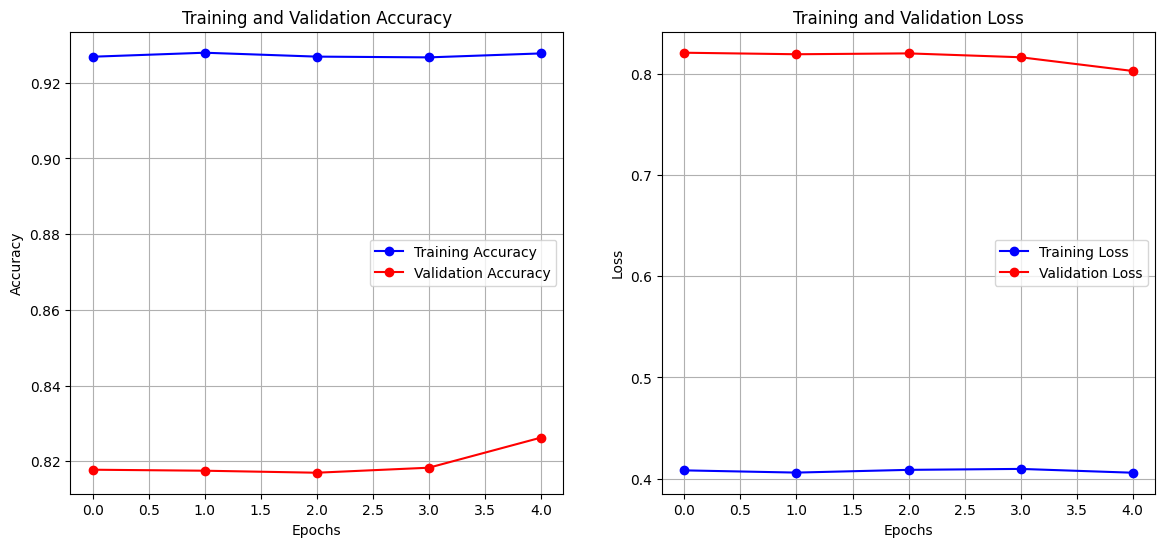

In [32]:
plot_history(history_model_6_fine_tune_5_perc)

step 3

In [33]:
for layer in model_6.layers[1].layers:
    layer.trainable = False

for layer in model_6.layers:
    layer.trainable = False

In [34]:
model_6 = unfreeze_top_layers(model_6, start_fraction=0.90, learning_rate=0.00001)
display_layers_info(model_6)


          Layer name: input_layer
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float32'>
          Layer compute dtype: float32

    

          Layer name: efficientnetb0
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: global_average_pooling_layer
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: dropout
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: logits_layer
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: activation_output_layer
 

In [35]:
for layer in model_6.layers[1].layers:
    print(layer.name, "\t", layer.trainable)

input_1 	 False
rescaling 	 False
normalization 	 False
rescaling_1 	 False
stem_conv_pad 	 False
stem_conv 	 False
stem_bn 	 False
stem_activation 	 False
block1a_dwconv 	 False
block1a_bn 	 False
block1a_activation 	 False
block1a_se_squeeze 	 False
block1a_se_reshape 	 False
block1a_se_reduce 	 False
block1a_se_expand 	 False
block1a_se_excite 	 False
block1a_project_conv 	 False
block1a_project_bn 	 False
block2a_expand_conv 	 False
block2a_expand_bn 	 False
block2a_expand_activation 	 False
block2a_dwconv_pad 	 False
block2a_dwconv 	 False
block2a_bn 	 False
block2a_activation 	 False
block2a_se_squeeze 	 False
block2a_se_reshape 	 False
block2a_se_reduce 	 False
block2a_se_expand 	 False
block2a_se_excite 	 False
block2a_project_conv 	 False
block2a_project_bn 	 False
block2b_expand_conv 	 False
block2b_expand_bn 	 False
block2b_expand_activation 	 False
block2b_dwconv 	 False
block2b_bn 	 False
block2b_activation 	 False
block2b_se_squeeze 	 False
block2b_se_reshape 	 False
bloc

In [36]:
history_model_6_fine_tune_10_perc = model_6.fit(train_data,
            epochs=15,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.15*len(test_data)),
            callbacks=prepare_callbacks(checkpoint_name="model_6_fine_tune_10_percent",
                                        logs_name="model_6_fine_tune_10_percent"),
            initial_epoch=10
            )

Epoch 11/15
2366/2368 [============================>.] - ETA: 0s - loss: 0.4164 - accuracy: 0.9249
Epoch 11: val_accuracy improved from -inf to 0.81621, saving model to ./checkpoints\model_6_fine_tune_10_percent.weights.h5
2368/2368 [==============================] - 60s 24ms/step - loss: 0.4164 - accuracy: 0.9249 - val_loss: 0.8248 - val_accuracy: 0.8162 - lr: 1.0000e-05
Epoch 12/15
2366/2368 [============================>.] - ETA: 0s - loss: 0.4153 - accuracy: 0.9245
Epoch 12: val_accuracy did not improve from 0.81621

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
2368/2368 [==============================] - 57s 24ms/step - loss: 0.4153 - accuracy: 0.9245 - val_loss: 0.8191 - val_accuracy: 0.8138 - lr: 1.0000e-05
Epoch 13/15
2366/2368 [============================>.] - ETA: 0s - loss: 0.4158 - accuracy: 0.9253
Epoch 13: val_accuracy did not improve from 0.81621

Epoch 13: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
2368/2368 [===

In [37]:
save_training_history(history_model_6_fine_tune_10_perc, "model_6_fine_tune_10_percent")

Training history saved to ./histories/json/model_6_fine_tune_10_percent.json


In [38]:
result_model_6_fine_tune_10_perc = model_6.evaluate(test_data)
result_model_6_fine_tune_10_perc

790/790 [==============================] - 16s 20ms/step - loss: 0.8258 - accuracy: 0.8109


[0.825800359249115, 0.8109306693077087]

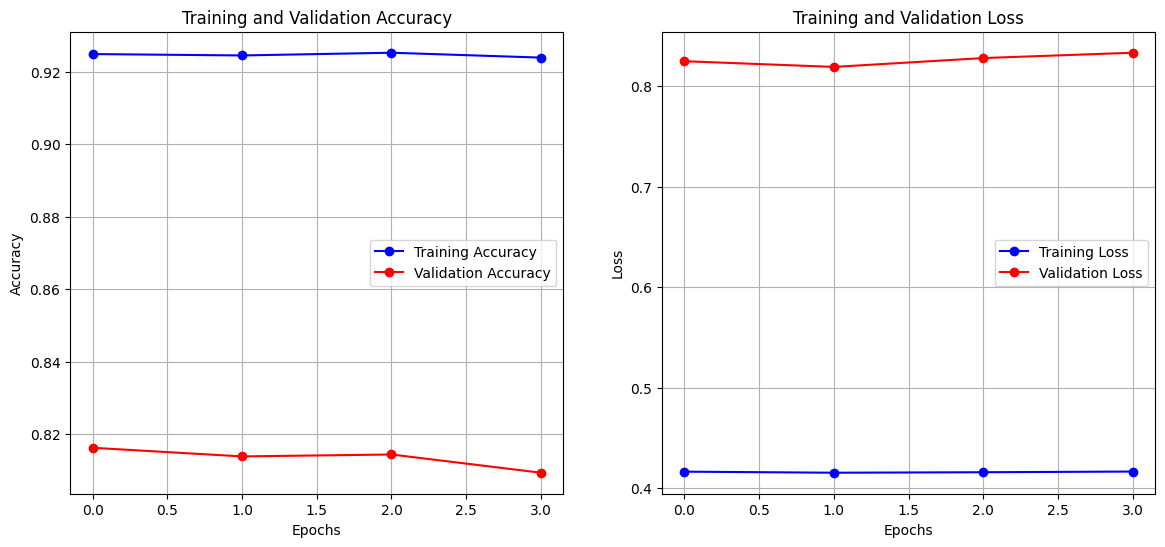

In [39]:
plot_history(history_model_6_fine_tune_10_perc)

step 4

In [40]:
for layer in model_6.layers[1].layers:
    layer.trainable = False

for layer in model_6.layers:
    layer.trainable = False

In [41]:
model_6 = unfreeze_top_layers(model_6, start_fraction=0.85, learning_rate=0.000001)
display_layers_info(model_6)


          Layer name: input_layer
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float32'>
          Layer compute dtype: float32

    

          Layer name: efficientnetb0
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: global_average_pooling_layer
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: dropout
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: logits_layer
          Trainable: False
          Layer dtype: float32
          Layer output dtype: <dtype: 'float16'>
          Layer compute dtype: float16

    

          Layer name: activation_output_layer
 

In [42]:
for layer in model_6.layers[1].layers:
    print(layer.name, "\t", layer.trainable)

input_1 	 False
rescaling 	 False
normalization 	 False
rescaling_1 	 False
stem_conv_pad 	 False
stem_conv 	 False
stem_bn 	 False
stem_activation 	 False
block1a_dwconv 	 False
block1a_bn 	 False
block1a_activation 	 False
block1a_se_squeeze 	 False
block1a_se_reshape 	 False
block1a_se_reduce 	 False
block1a_se_expand 	 False
block1a_se_excite 	 False
block1a_project_conv 	 False
block1a_project_bn 	 False
block2a_expand_conv 	 False
block2a_expand_bn 	 False
block2a_expand_activation 	 False
block2a_dwconv_pad 	 False
block2a_dwconv 	 False
block2a_bn 	 False
block2a_activation 	 False
block2a_se_squeeze 	 False
block2a_se_reshape 	 False
block2a_se_reduce 	 False
block2a_se_expand 	 False
block2a_se_excite 	 False
block2a_project_conv 	 False
block2a_project_bn 	 False
block2b_expand_conv 	 False
block2b_expand_bn 	 False
block2b_expand_activation 	 False
block2b_dwconv 	 False
block2b_bn 	 False
block2b_activation 	 False
block2b_se_squeeze 	 False
block2b_se_reshape 	 False
bloc

In [44]:
history_model_6_fine_tune_15_perc = model_6.fit(train_data,
            epochs=20,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.15*len(test_data)),
            callbacks=prepare_callbacks(checkpoint_name="model_6_fine_tune_15_percent",
                                        logs_name="model_6_fine_tune_15_percent"),
            initial_epoch=15
            )

Epoch 16/20
2368/2368 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.9243
Epoch 16: val_accuracy improved from -inf to 0.81700, saving model to ./checkpoints\model_6_fine_tune_15_percent.weights.h5
2368/2368 [==============================] - 58s 24ms/step - loss: 0.4162 - accuracy: 0.9243 - val_loss: 0.8207 - val_accuracy: 0.8170 - lr: 1.0000e-06
Epoch 17/20
2366/2368 [============================>.] - ETA: 0s - loss: 0.4164 - accuracy: 0.9244
Epoch 17: val_accuracy did not improve from 0.81700

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.9999999949504855e-07.
2368/2368 [==============================] - 56s 24ms/step - loss: 0.4163 - accuracy: 0.9244 - val_loss: 0.8287 - val_accuracy: 0.8114 - lr: 1.0000e-06
Epoch 18/20
2367/2368 [============================>.] - ETA: 0s - loss: 0.4188 - accuracy: 0.9236
Epoch 18: val_accuracy improved from 0.81700 to 0.82018, saving model to ./checkpoints\model_6_fine_tune_15_percent.weights.h5
2368/2368 [======

In [45]:
save_training_history(history_model_6_fine_tune_15_perc, "model_6_fine_tune_15_percent")

Training history saved to ./histories/json/model_6_fine_tune_15_percent.json


In [46]:
result_model_6_fine_tune_15_perc = model_6.evaluate(test_data)
result_model_6_fine_tune_15_perc

790/790 [==============================] - 16s 21ms/step - loss: 0.8272 - accuracy: 0.8107


[0.8271746039390564, 0.8107326626777649]

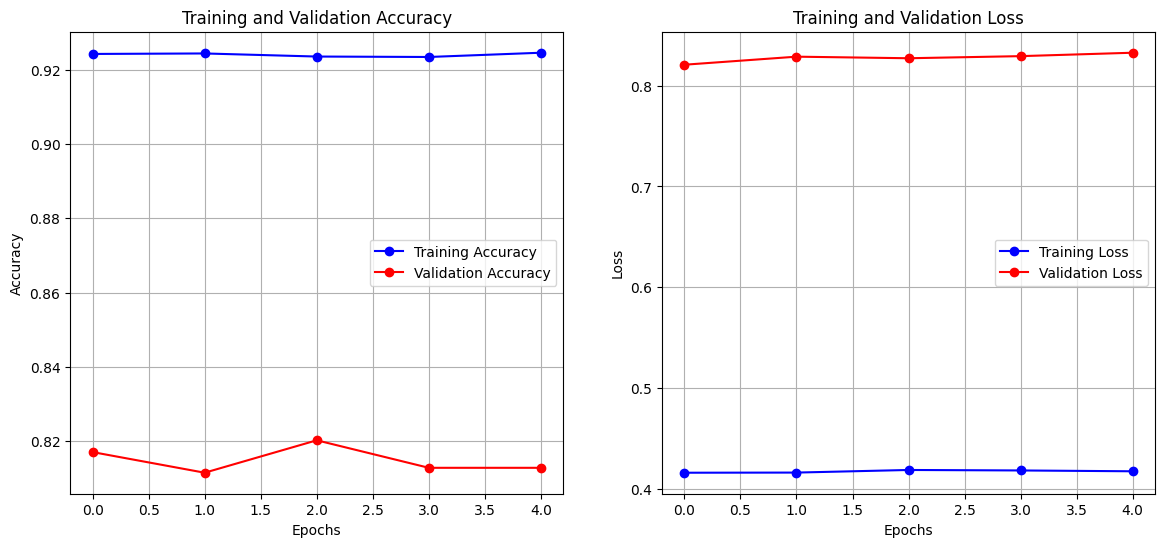

In [ ]:
plot_history(history_model_6_fine_tune_15_perc)

### **Experiment 6: Conclusion**  

**Model_6** achieved a **new highest validation accuracy of 81%**, surpassing all previous models.  
However, this improvement comes with significant drawbacks.  

**Key Observations:**  
✅ **Higher accuracy** than Model_4 (80%) and Model_3 (75%).  
✅ **Lower validation loss**, indicating better optimization.  
❌ **Severe overfitting** observed in loss curves—suggesting the model is **memorizing training data** rather than generalizing.  
❌ While **extended training (20 epochs)** helped improve accuracy, it also **led to significant overfitting**, raising concerns about real-world performance on unseen data.  

**Conclusion:**  
Despite the accuracy improvement, **progressive fine-tuning in this setup leads to excessive overfitting**.  
Since **Model_4 achieved competitive performance with only 5 epochs and without overfitting**, it will be chosen as the **final architecture**.  
Fine-tuning may still be explored in future work, but with **stronger regularization techniques** to prevent overfitting.